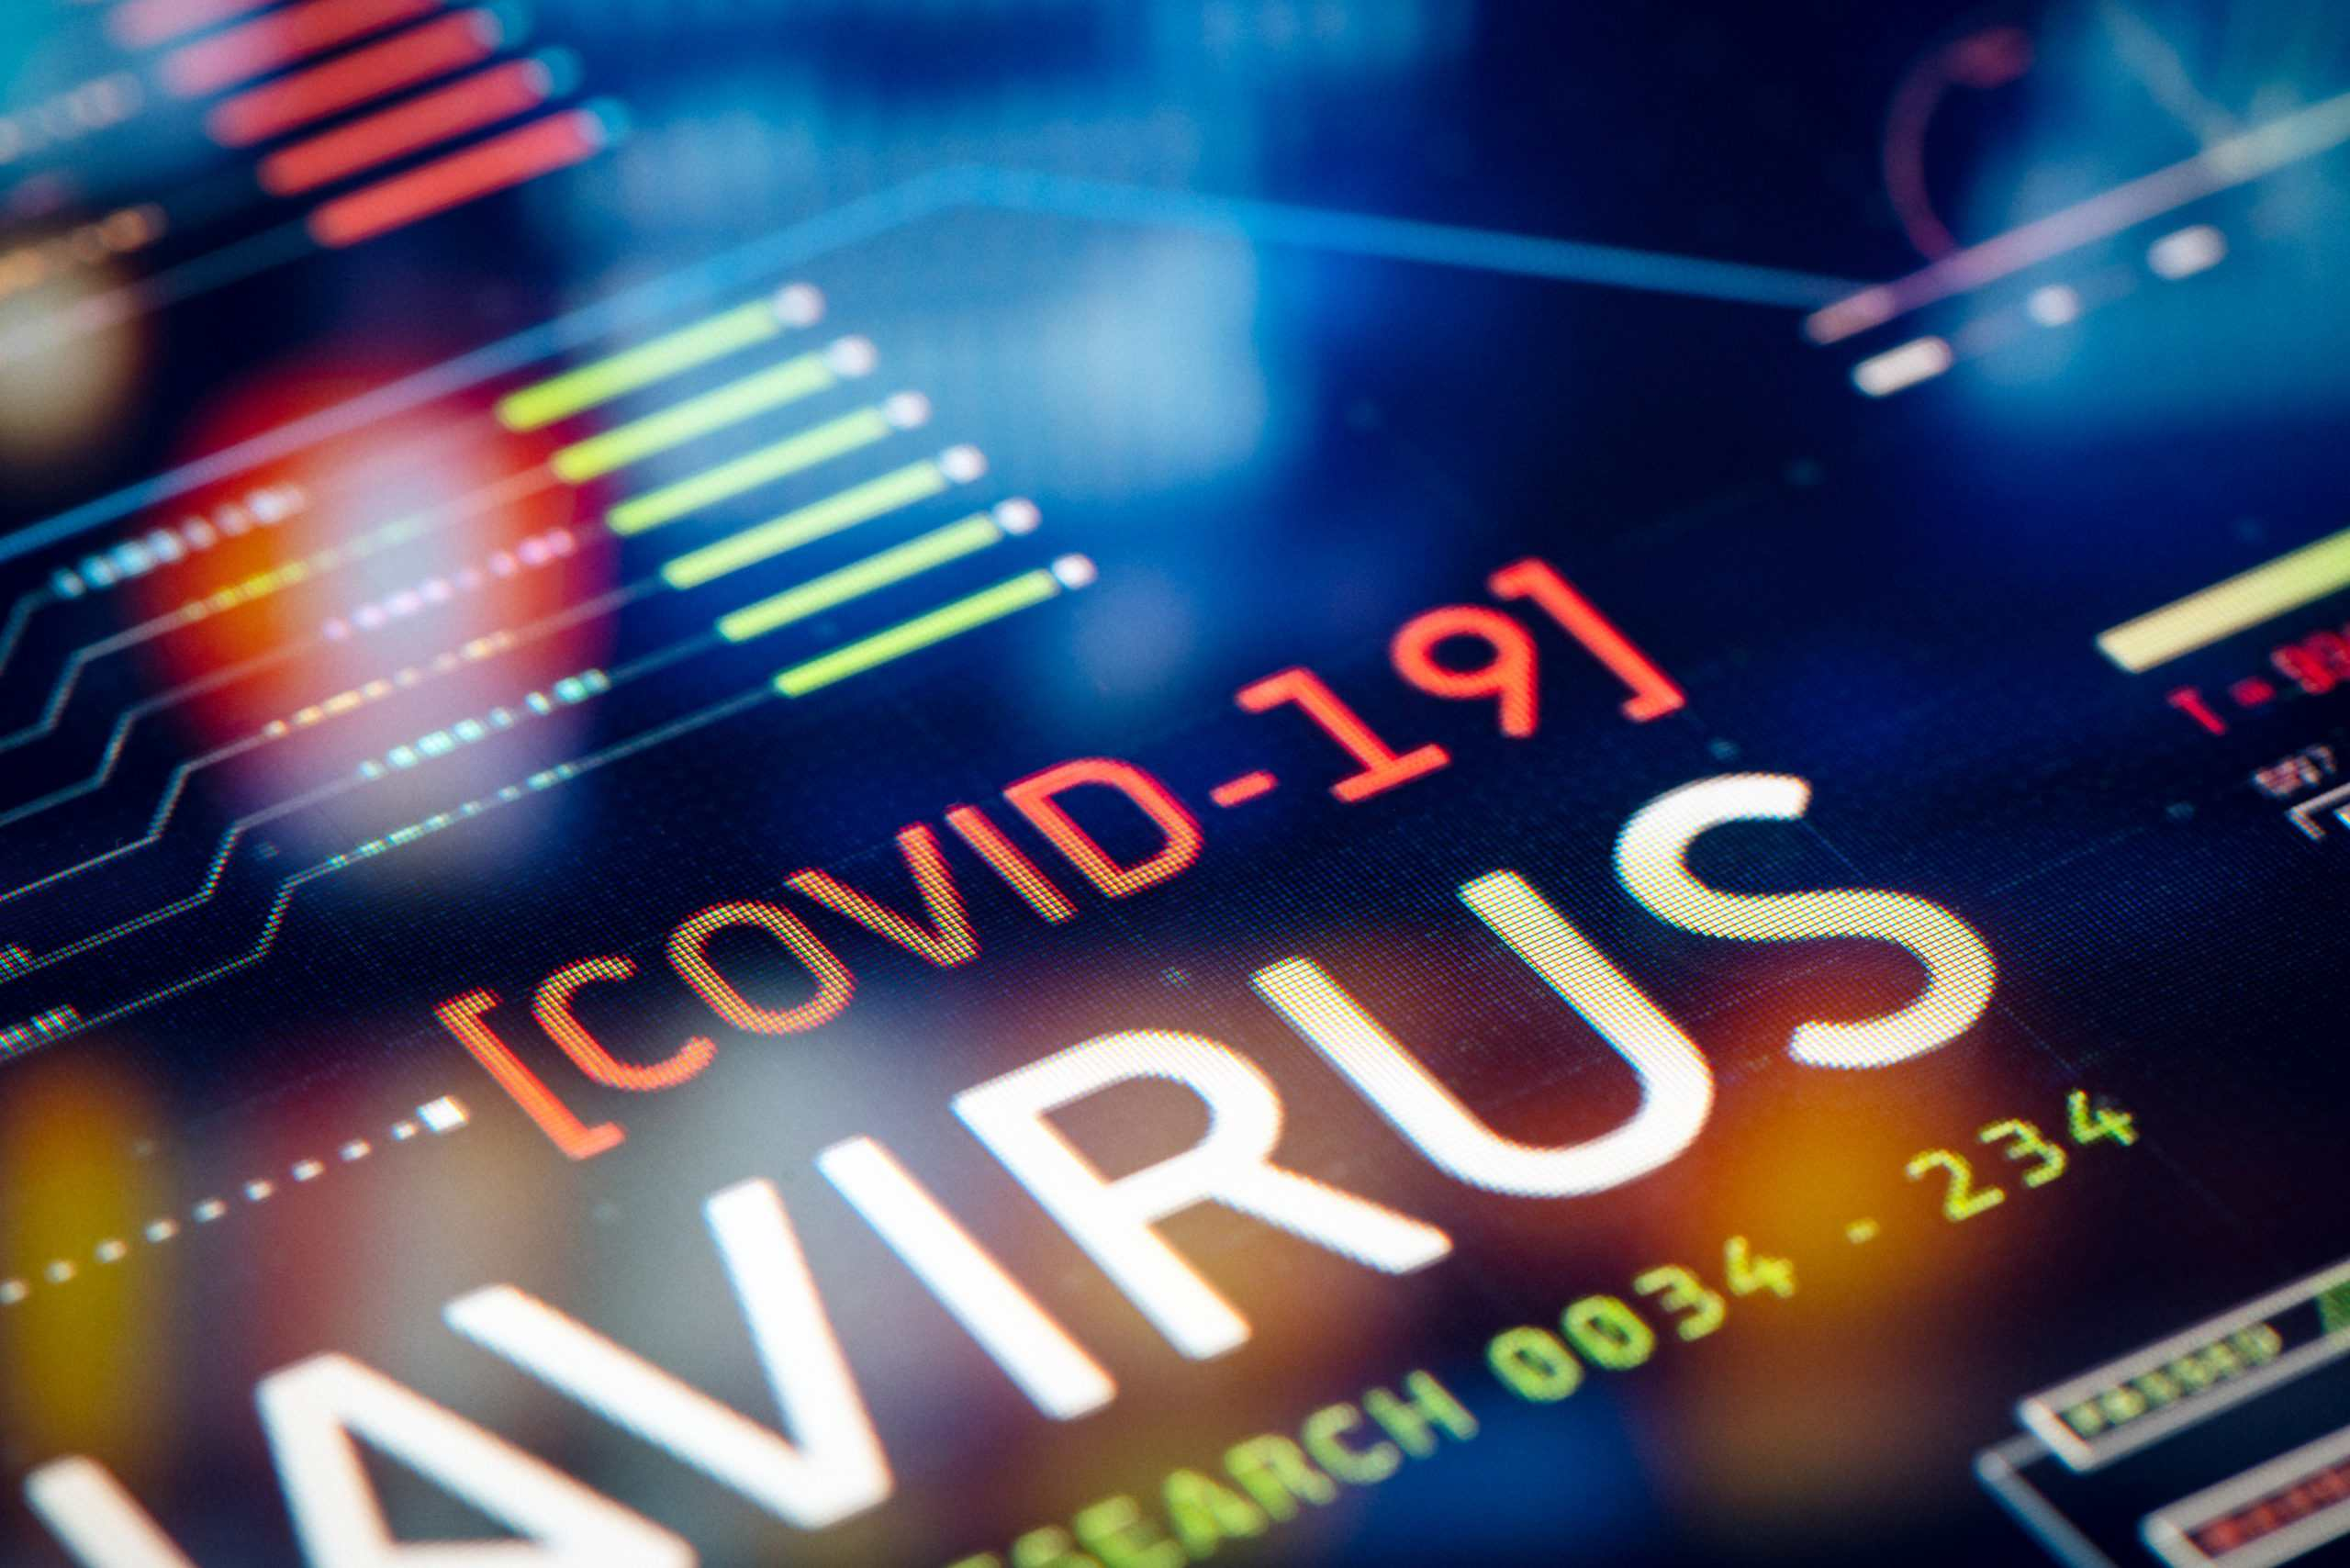
# Bert-QA with BM25 search engine
This project use Bert model that further pre-trained on paper corpus and fine-tuned on SQuAD dataset to extract possiable answers from given papers. We use BM25 search engine to filter several most relative papers and rank them by relation score. Then we feed these papers and the questions to Bert which has been fine-tuned for question answering. Finally, we list each answer that produces by Bert in a table.

## Background
### Bert for QA
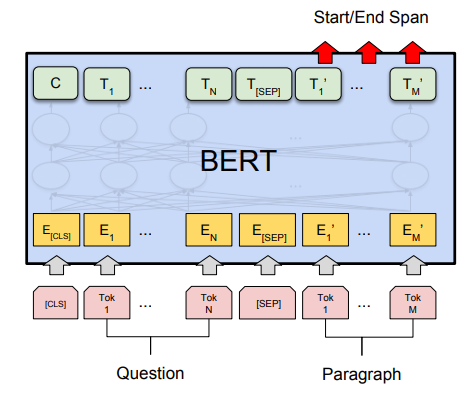

BERT (Bidirectional Encoder Representations from Transformers) is a recent paper published by researchers at Google AI Language. It has caused a stir in the Machine Learning community by presenting state-of-the-art results in a wide variety of NLP tasks, including Question Answering (SQuAD v1.1), Natural Language Inference (MNLI), and others.

BERT’s key technical innovation is applying the bidirectional training of Transformer, a popular attention model, to language modelling. This is in contrast to previous efforts which looked at a text sequence either from left to right or combined left-to-right and right-to-left training. The paper’s results show that a language model which is bidirectionally trained can have a deeper sense of language context and flow than single-direction language models. In the paper, the researchers detail a novel technique named Masked LM (MLM) which allows bidirectional training in models in which it was previously impossible.

Question answering (QA) is a computer science discipline within the fields of information retrieval and natural language processing (NLP), which is concerned with building systems that automatically answer questions posed by humans in a natural language


### BM25
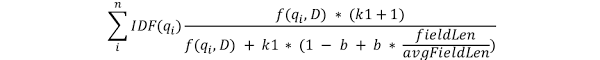
In information retrieval, Okapi BM25 (BM is an abbreviation of best matching) is a ranking function used by search engines to estimate the relevance of documents to a given search query. It is based on the probabilistic retrieval framework developed in the 1970s and 1980s by Stephen E. Robertson, Karen Spärck Jones, and others.

The name of the actual ranking function is BM25. The fuller name, Okapi BM25, includes the name of the first system to use it, which was the Okapi information retrieval system, implemented at London's City University in the 1980s and 1990s. BM25 and its newer variants, e.g. BM25F (a version of BM25 that can take document structure and anchor text into account), represent state-of-the-art TF-IDF-like retrieval functions used in document retrieval.

## Install and import packages
Install and import packages

In [ ]:
!pip install rank_bm25 nltk

from transformers import BertTokenizer, BertForQuestionAnswering
import torch
import numpy as np

import os
import json
from tqdm import tqdm


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path, PurePath
import pandas as pd
import requests
from requests.exceptions import HTTPError, ConnectionError
from ipywidgets import interact
import ipywidgets as widgets
from rank_bm25 import BM25Okapi
import nltk
from nltk.corpus import stopwords
nltk.download("punkt")
import re

from ipywidgets import interact
import ipywidgets as widgets
import pandas as pd

def set_column_width(ColumnWidth, MaxRows):
    pd.options.display.max_colwidth = ColumnWidth
    pd.options.display.max_rows = MaxRows
    print('Set pandas dataframe column width to', ColumnWidth, 'and max rows to', MaxRows)
    
interact(set_column_width, 
         ColumnWidth=widgets.IntSlider(min=50, max=400, step=50, value=200),
         MaxRows=widgets.IntSlider(min=50, max=500, step=100, value=100));

## Data Preprocess

Load full-text paper and clean them. Read json files and build dataframe with two columns: sha, text. We will merge this with metadata in the following cell.

In [ ]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            if fullPath[-5:] == '.json': allFiles.append(fullPath)
                
    return allFiles

#extracts the abstract and body text of a .json file
def clean_json(path):
    #loads json file into a string
    with open(path) as f:
        dic = json.load(f)
        
    try:    
        paper_id = dic['paper_id']
    
        abstract = dic['abstract'][0]['text']
    except:
        abstract= ""
    txt= ""
    for i in range(len(dic['body_text'])):
        par = dic['body_text'][i]['text']
        txt = txt + ' ' + par
    return paper_id, abstract, txt

#getting all the paths into a list
paths = getListOfFiles('/kaggle/input/CORD-19-research-challenge')


ids = []
abstracts = []
texts = []
for path in tqdm(paths):
    paper_id, abstract, txt = clean_json(path)
    ids.append(paper_id)
    abstracts.append(abstract)
    texts.append(txt)
        
ids_texts = pd.DataFrame(data=list(zip(ids, texts)),columns=['sha', 'text'])

Read metadata file and build a dataframe to store. Drop items which don't have full text.

In [ ]:
# Where are all the files located
input_dir = PurePath('../input/CORD-19-research-challenge')
metadata_path = input_dir / 'metadata.csv'
metadata = pd.read_csv(metadata_path, dtype={'Microsoft Academic Paper ID': str,
                                              'pubmed_id': str})

# Set the abstract to the paper title if it is null
metadata.abstract = metadata.abstract.fillna(metadata.title)

#all articles with sha
with_sha = metadata.loc[~metadata.sha.isnull()]

#all articles without sha (doesn't have the full text)
not_sha = metadata.loc[metadata.sha.isnull()]

#If no sha, then use the abstract as the text of the article.
not_sha['text'] = not_sha['abstract']

#If the article doesn't have the abstract,then use the title
idx = not_sha.loc[not_sha.text.isnull()].index
not_sha.text.loc[idx] = not_sha.title.loc[idx]

#if it doesn't have a title, then drop it
not_sha.drop(not_sha.text.isnull().index,inplace=True)

#now merging the metadata with the dataframe that has the full texts
merged = with_sha.merge(ids_texts, on=['sha'], how='inner')
merged = pd.concat((merged, not_sha))
merged = merged.reset_index()
merged.head()

Create class Paper to make it easier to get some field like abstract, full text, doi and so on.

In [ ]:
def get(url, timeout=6):
    try:
        r = requests.get(url, timeout=timeout)
        return r.text
    except ConnectionError:
        print(f'Cannot connect to {url}')
        print(f'Remember to turn Internet ON in the Kaggle notebook settings')
    except HTTPError:
        print('Got http error', r.status, r.text)

# Convert the doi to a url
def doi_url(d): 
    return f'http://{d}' if d.startswith('doi.org') else f'http://doi.org/{d}'


# class AllPaperData:
#     def __init__(self, metadata: pd.DataFrame):
#         self.metadata = metadata
        
#     def __getitem__(self, item):
#         return Paper(self.metadata.iloc[item])
    
#     def __len__(self):
#         return len(self.metadata)
    
#     def head(self, n):
#         return AllPaperData(self.metadata.head(n).copy().reset_index(drop=True))
    
#     def tail(self, n):
#         return AllPaperData(self.metadata.tail(n).copy().reset_index(drop=True))

#     def abstracts(self):
#         return self.metadata.abstract.dropna()
    
#     def titles(self):
#         return self.metadata.title.dropna()
        
#     def _repr_html_(self):
#         return self.metadata._repr_html_()
    
class Paper:
    def __init__(self, item):
        self.paper = item.to_frame().fillna('')
        self.paper.columns = ['Value']
    
    def doi(self):
        return self.paper.loc['doi'].values[0]
    
    def html(self):
        '''
        Load the paper from doi.org and display as HTML. Requires internet to be ON
        '''
        if self.doi():
            url = doi_url(self.doi())
            text = get(url)
            return widgets.HTML(text)
    
    def text(self):
        '''
        Load the paper from doi.org and display as text. Requires Internet to be ON
        '''
#         text = get(self.doi())
        return self.paper.loc['text'].values[0]
    
    def abstract(self):
        return self.paper.loc['abstract'].values[0]
    
    def title(self):
        return self.paper.loc['title'].values[0]
    
    def authors(self, split=False):
        '''
        Get a list of authors
        '''
        authors = self.paper.loc['authors'].values[0]
        if not authors:
            return []
        if not split:
            return authors
        if authors.startswith('['):
            authors = authors.lstrip('[').rstrip(']')
            return [a.strip().replace("\'", "") for a in authors.split("\',")]
        
        # Todo: Handle cases where author names are separated by ","
        return [a.strip() for a in authors.split(';')]
        
    def _repr_html_(self):
        return self.paper._repr_html_()
    

# papers = AllPaperData(merged)

Some preprocess functions to clean the origin data. We tokenize the text, remove punctuation and some special characters.

In [ ]:
english_stopwords = list(set(stopwords.words('english')))
SEARCH_DISPLAY_COLUMNS = ['title', 'abstract', 'doi', 'authors', 'journal', 'text']

def strip_characters(text):
    t = re.sub('\(|\)|:|,|;|\.|’|”|“|\?|%|>|<', '', text)
    t = re.sub('/', ' ', t)
    t = t.replace("'",'')
    return t

def clean(text):
    t = text.lower()
    t = strip_characters(t)
    return t

def tokenize(text):
    words = nltk.word_tokenize(text)
    return list(set([word for word in words 
                     if len(word) > 1
                     and not word in english_stopwords
                     and not (word.isnumeric() and len(word) is not 4) # don't remove years
                     and (not word.isnumeric() or word.isalpha())] )
               )

def preprocess(text):
    t = clean(text)
    tokens = tokenize(t)
    return tokens

## BM25 Search Engine
Define class to handle index building and string searching.

In [ ]:
class SearchResults:
    def __init__(self,
                 data: pd.DataFrame,
                 columns = None):
        self.results = data
        if columns:
            self.results = self.results[columns]
            
    def __getitem__(self, item):
        return Paper(self.results.loc[item])
    
    def __len__(self):
        return len(self.results)
        
    def _repr_html_(self):
        return self.results._repr_html_()
    
    def set_ans(self, ans):
        col_name = self.results.columns.tolist()
        col_name.insert(2,'Answer')
        self.results = self.results.reindex(columns=col_name)
        self.results['Answer'] = ans
        
class WordTokenIndex:
    def __init__(self, 
                 corpus: pd.DataFrame, 
                 columns=SEARCH_DISPLAY_COLUMNS):
        self.corpus = corpus
        # Use abstart and title to create index
        raw_search_str = self.corpus.abstract.fillna('') + ' ' + self.corpus.title.fillna('')
        self.index = raw_search_str.apply(preprocess).to_frame()
        self.index.columns = ['terms']
        self.index.index = self.corpus.index
        self.columns = columns
    
    def search(self, search_string):
        search_terms = preprocess(search_string)
        # get indexs that include the search_string
        result_index = self.index.terms.apply(lambda terms: any(i in terms for i in search_terms))
        # get searched papers
        results = self.corpus[result_index].copy().reset_index().rename(columns={'index':'paper'})
        return SearchResults(results, self.columns + ['paper'])
    
class RankBM25Index(WordTokenIndex):
    ''' Rank '''
    def __init__(self, corpus: pd.DataFrame, columns=SEARCH_DISPLAY_COLUMNS):
        super().__init__(corpus, columns)
        self.bm25 = BM25Okapi(self.index.terms.tolist())
        
    def search(self, search_string, n=4):
        search_terms = preprocess(search_string)
        doc_scores = self.bm25.get_scores(search_terms)
        
        ind = np.argsort(doc_scores)[::-1][:n]
        results = self.corpus.iloc[ind][self.columns]
        results['Score'] = doc_scores[ind]
        results = results[results.Score > 0]
        return SearchResults(results.reset_index(), self.columns + ['Score'])

## Bert furtuer pre-train and fine-tune
Use transformers bert implementation and load the pre-trained model 'bert-base-uncased'. We use all papers as corpus to further pre-train the bert with language model task. After further pre-train, we use SQuAD-2.0 dataset to fine-tune the bert model. Finally, we save the trained model which named as "output_squad".

In [ ]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('/kaggle/input/bert-covid/output_squad')
model = BertForQuestionAnswering.from_pretrained('/kaggle/input/bert-covid/output_squad')

## QA function
Create QA function which receive a question and a piece of text, feed them in to bert model and output the possible answer in the text. If model outputs invalid answer, the function will output "No Answer".

In [ ]:
max_question_len = 100
def getAnswer(question, text):
    input_ids = tokenizer.encode(question, text, max_length=512)
    token_type_ids = [0 if i <= input_ids.index(102) else 1 for i in range(len(input_ids))]
#     print(len(input_ids))
    start_scores, end_scores = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([token_type_ids]))
    all_tokens = tokenizer.convert_ids_to_tokens(input_ids)
    start_scores = start_scores[0, input_ids.index(102):]
    end_scores = end_scores[0, input_ids.index(102):]
    if torch.argmax(start_scores).item() >= torch.argmax(end_scores).item():
        return "No Answer"
#     print(input_ids.index(102) + torch.argmax(start_scores))
#     print(input_ids.index(102) + torch.argmax(end_scores) + 1)
    all_tokens = all_tokens[: input_ids.index(102) + torch.argmax(start_scores)] + ["【"] + all_tokens[input_ids.index(102) + torch.argmax(start_scores):]
    all_tokens = all_tokens[: input_ids.index(102) + torch.argmax(end_scores) + 1] + ["】"] + all_tokens[input_ids.index(102) + torch.argmax(end_scores) + 1:]
    start_span = max(input_ids.index(102) + torch.argmax(start_scores) - 5, input_ids.index(102))
    end_span = min(input_ids.index(102) + torch.argmax(end_scores) + 6, len(all_tokens) + 1)

    answer = tokenizer.convert_tokens_to_string(all_tokens[start_span : end_span])
    answer = answer.replace("[SEP]", "")
    return answer


def searchAndGetAnswer(question):
    # Filter out relevant papers
    results = bm25_index.search(question, 50)

#     print("Search item num: %d" % len(results))

    # Get answers
    ans_list = []
    ans_index = []
    for i in range(len(results)):
        text = results[i].text()
        ans = getAnswer(question, text)
        if ans == "No Answer":
            continue
        ans_list.append(ans)
        ans_index.append(i)
        print("{}/{}".format(len(ans_index), 10))
        if len(ans_index) >= 10:
            break
    results.results = results.results.loc[ans_index, :].reset_index()

    # Append to metadata
    results.set_ans(ans_list)
    
    # Change the order
    cols=['title','abstract','Answer','Score','doi','authors','journal']
    res = results.results.loc[:,cols]
    return res

## Build pipeline and show results
We show the model output in tables and enclosed them with "【】" to represent the answer in the paper.

In [ ]:
# Build index on coprus
bm25_index = RankBM25Index(merged)

### Q1: *Real-time tracking of whole genomes and a mechanism for coordinating the rapid dissemination of that information to inform the development of diagnostics and therapeutics and to track variations of the virus over time.*

In [ ]:
p = "Real-time tracking of whole genomes and a mechanism for coordinating the rapid dissemination of that information to inform the development of diagnostics and therapeutics and to track variations of the virus over time."
res = searchAndGetAnswer(p)
res

### Q2: *Access to geographic and temporal diverse sample sets to understand geographic distribution and genomic differences, and determine whether there is more than one strain in circulation. Multi-lateral agreements such as the Nagoya Protocol could be leveraged.*

In [ ]:
p = "Access to geographic and temporal diverse sample sets to understand geographic distribution and genomic differences, and determine whether there is more than one strain in circulation. Multi-lateral agreements such as the Nagoya Protocol could be leveraged."
res = searchAndGetAnswer(p)
res

### Q3: *Evidence that livestock could be infected (e.g., field surveillance, genetic sequencing, receptor binding) and serve as a reservoir after the epidemic appears to be over.*
* Evidence of whether farmers are infected, and whether farmers could have played a role in the origin.
* Surveillance of mixed wildlife- livestock farms for SARS-CoV-2 and other coronaviruses in Southeast Asia.
* Experimental infections to test host range for this pathogen.

In [ ]:
p = '''
Evidence that livestock could be infected (e.g., field surveillance, genetic sequencing, receptor binding) and serve as a reservoir after the epidemic appears to be over.
Evidence of whether farmers are infected, and whether farmers could have played a role in the origin.
Surveillance of mixed wildlife- livestock farms for SARS-CoV-2 and other coronaviruses in Southeast Asia.
Experimental infections to test host range for this pathogen.
'''
res = searchAndGetAnswer(p)
res

### Q4: *Animal host(s) and any evidence of continued spill-over to humans*

In [ ]:
p = '''
Animal host(s) and any evidence of continued spill-over to humans
'''
res = searchAndGetAnswer(p)
res

### Q5: *Socioeconomic and behavioral risk factors for this spill-over*

In [ ]:
p = '''
Socioeconomic and behavioral risk factors for this spill-over
'''
res = searchAndGetAnswer(p)
res

### Q6: *Sustainable risk reduction strategies*

In [ ]:
p = '''
Sustainable risk reduction strategies
'''
res = searchAndGetAnswer(p)
res